Cumulateive distribution function (CDF):

$F_X(x)=Pr(X\leq x)$

Pecentile point function (PPF):

$Q_X(p)=\inf\{x\in R:Pr(X\leq x)\geq p \}$

$Q_X(p)=\inf\{x\in R:F_X(x)\geq p \}$

Trivially we have, $Q_X(F_X(x))=x$

Consider

$\phi(p) =F_{X+Y}(Q_X(p)+Q_Y(p))-p$

In [1]:
# import util
from pymisc.util import *
# import vis_util 
from pymisc.vis_util import *
import scipy.stats as spstat
import scipy.integrate as spint



is in ipython: 1
[WARN] pymisc.vis_util cannot find network


In [2]:
from scipy.stats._distn_infrastructure import argsreduce,place,shape,zeros,ones
def fpdf(self,x,*args,**kwds):
    '''
    Faster pdf without error checking
    '''
    dtyp=np.float64
    args, loc, scale = self._parse_args(*args, **kwds)
    x = np.asarray((x - loc)/scale, dtype=dtyp)

    cond = ones(shape(x), dtyp)
#     cond = self._argcheck(*args) & (scale > 0)
#     cond0 = self._argcheck(*args) & (scale > 0)
#     cond1 = self._support_mask(x) & (scale > 0)
#     cond = cond0 & cond1

#     goodargs = argsreduce(cond, *((x,)+args+(scale,)))
#     goodargs = (x,)+args+(scale,)

#     scale, goodargs = goodargs[-1], goodargs[:-1]
    
    goodargs = (x,) + args
    
    output = zeros(shape(cond), dtyp)
    place(output, cond, self._pdf(*goodargs) / scale)
    return output
def make_fpdf(p1):
    def pdf(x):
        return fpdf(p1.dist,x,*p1.args,**p1.kwds)
    return pdf

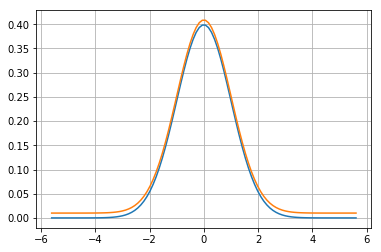

The slowest run took 4.29 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 13.9 µs per loop
The slowest run took 13.90 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 107 µs per loop


In [3]:
# f = lambda x:fpdf(p1.dist,x,*p1.args,**p1.kwds)

p1 =spstat.norm(loc=0,scale=1)
p2 =spstat.norm(loc=0,scale=1)

f = make_fpdf(p1)
rg = map(p1.ppf,[1E-8,1-1E-8])
preview(f,rg=rg)
plt.grid()
preview(lambda x:p1.pdf(x)+0.01,rg=rg)
plt.show()
%timeit f(-10)
%timeit p1.pdf(-10)


CPU times: user 116 ms, sys: 12 ms, total: 128 ms
Wall time: 115 ms


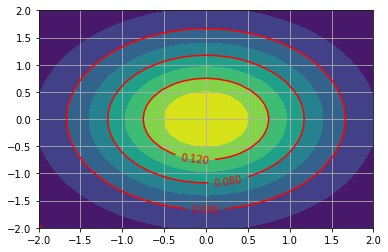

CPU times: user 216 ms, sys: 60 ms, total: 276 ms
Wall time: 195 ms


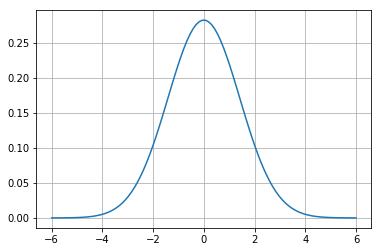

In [4]:

   
def joint_p(p1,p2,log=0):
    '''
    Calculate joint dist P(X,Y)=P(X)*P(Y)
    '''
    
    if log:
        def jpdf(x1,x2):
            val = p1.logpdf(x1) + p2.logpdf(x2)
            return val
    else:
        pdf1 = make_fpdf(p1)
        pdf2 = make_fpdf(p2)
        def jpdf(x1=None,x2=None):
            val = pdf1(x1) * pdf2(x2)
            return val
    return jpdf

def make_spdf(p1,p2,epsrel=1E-4,epsabs=0.0001,
             cutoff=1E-5):
    '''
    Calculate PDF for the distribution of sum: P(X+Y=x)
    '''
    jpdf = joint_p(p1,p2)

    p1.lo = p1.ppf(cutoff)
    p1.hi = p1.ppf(1-cutoff)
    p2.lo = p2.ppf(cutoff)
    p2.hi = p2.ppf(1-cutoff)
    def spdf(s
#              ,p1=None,p2=None
            ): 
        int2 = [s-p2.hi, s - p2.lo]
        lo = max(int2[0],p1.lo)
        hi = min(int2[1],p1.hi)
        if lo > hi:
            return 0.
        else:
            f = lambda x1:jpdf(x1,s-x1)
            return spint.quad(f,lo,hi,
                              epsabs=epsabs,epsrel=epsrel)[0]
#     spdf = functools.partial(spdf,p1=p1,p2=p2)
    return np.vectorize(spdf)
    
import copy
def make_scdf(p1,p2,cutoff=1E-3,num=100,nCPU = 1):
    '''
    Calculate CDF for the sum (P(X+Y<=x) )
    '''
    spdf = make_spdf(p1,p2,cutoff=cutoff)
#     del p1.hi
    rg = map(lambda p:p1.ppf(p)+p2.ppf(p),[cutoff,1-cutoff])
    xs = np.linspace(*rg,num=num)
#     ys = mp_map(spdf,xs)
    ys = spdf(xs)
    ys = np.cumsum(ys)*(xs[1]-xs[0])
    xs = (xs[1:]+xs[:-1])/2.
    ys = ys[:-1]
    scdf = functools.partial(np.interp,xp=xs,fp=ys)
    return scdf

def make_sppf(p1,p2,*args):
    '''wrapper function'''
    scdf = make_scdf(p1,p2,*args)
    return invert_interp(scdf)
# jpdf = joint_p(p1,p2)
if __name__=='__main__':
    p1 =spstat.norm(loc=0,scale=1)
    p2 =spstat.norm(loc=0,scale=1)

    jpdf = joint_p(p1,p2)
    %time dmet_2d(jpdf);
    plt.show()

    spdf = make_spdf(p1,p2)
    %time preview(spdf,rg=[-6,6])
    plt.show()
# spint.dblquad()
# spint.dblquad( jpdf, -4, 4, , lambda _:4, args=(), epsabs=1.49e-08, epsrel=1.49e-08)

In [5]:
def main(p1,p2,cutoff=1E-3,num=100):
    '''
    Plotting utility
    '''
    scdf = make_scdf(p1,p2,cutoff=cutoff,num=num)
    Gp = lambda p: scdf(p1.ppf(p)+p2.ppf(p))-p
    
    fig,axs = plt.subplots(1,3,figsize=[12,4])
    
    plt.sca(axs[0])
    preview(p1.ppf,label='X')
    preview(p2.ppf,label='Y')
    plt.title('PPF for X and Y')
    plt.grid()
    plt.legend()
    
    plt.sca(axs[1])
    preview(scdf,rg=map(invert_interp(scdf),[0.001,0.999]) )
    plt.ylim(-.1,1.1)
    plt.title('CDF for X+Y')
    
    plt.sca(axs[2])
    preview(Gp)
    plt.hlines(xmin=0,xmax=1,y=0,linestyles='--')
    plt.plot(0.5,Gp(0.5),'x')
    plt.title('G(p)\n'+'G(0.5)=%.3E'%(Gp(0.5)))
    print 'Gp(0.5)=',Gp(0.5)
    
    plt.show()

Gp(0.5)= -2.00009413476e-08


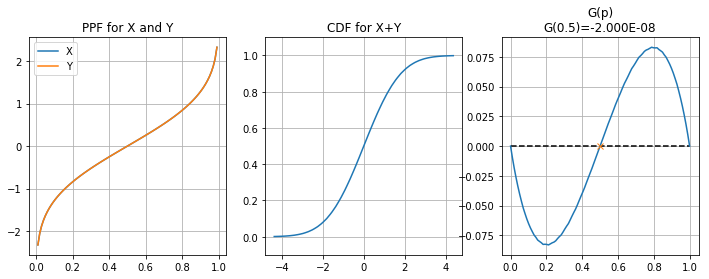

CPU times: user 668 ms, sys: 468 ms, total: 1.14 s
Wall time: 595 ms


In [6]:
%%time
p1 =spstat.norm(loc=0,scale=1)
p2 =spstat.norm(loc=0,scale=1)
main(p1,p2,cutoff=1E-8)

Gp(0.5)= -2.00400013806e-08


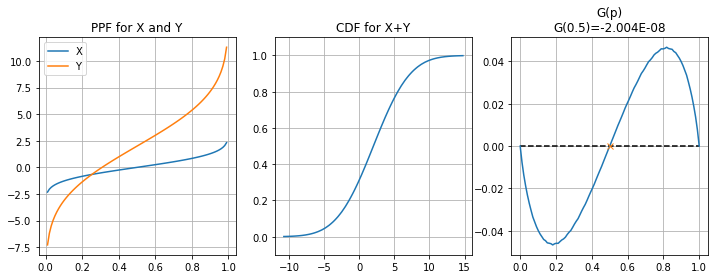

CPU times: user 768 ms, sys: 484 ms, total: 1.25 s
Wall time: 616 ms


In [7]:
%%time
p1 =spstat.norm(loc=0,scale=1)
p2 =spstat.norm(loc=2,scale=4)
main(p1,p2,cutoff=1E-8)

Gp(0.5)= -0.0256325864805


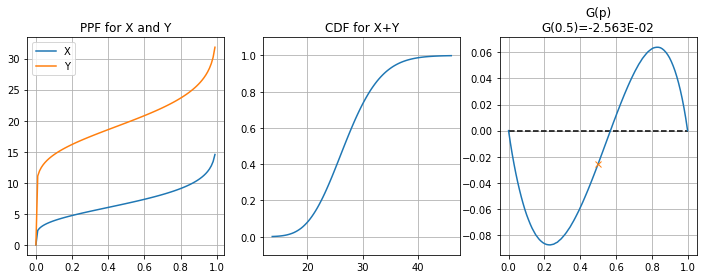

In [8]:
p1 =spstat.gamma(loc=0, a= 7)
p2 =spstat.gamma(loc=0, a= 20)
main(p1,p2,cutoff=1E-8,num=200)

Gp(0.5)= -0.0256325864805


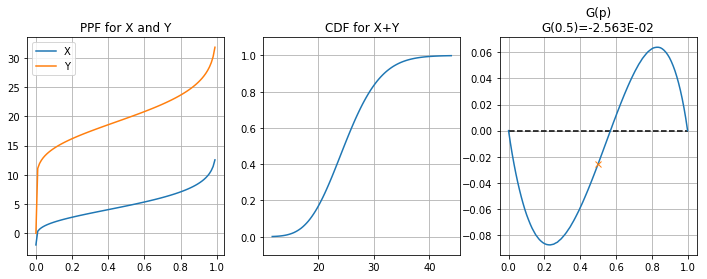

0.0	-2.0	0.0	0.0
0.2	2.7337	16.1725	-0.0869
0.4	4.0392	18.567	-0.0591
0.6	5.3426	20.8111	0.0111
0.8	7.0754	23.6343	0.0625
1.0	inf	inf	-0.0


In [13]:
p1 =spstat.gamma(loc=-2, a= 7)
p2 =spstat.gamma(loc=0, a= 20)
main(p1,p2,cutoff=1E-8,num=200)
scdf = make_scdf(p1,p2,cutoff=1E-8)
Gp = lambda p: scdf(p1.ppf(p)+p2.ppf(p))-p
ps = np.arange(0,1.1,0.2)
arr = [ps,p1.ppf(ps),p2.ppf(ps),Gp(ps)]
arr = np.transpose(arr)

from pymisc.util import mat2str

print mat2str(arr,4)

Gp(0.5)= -0.0322492319961


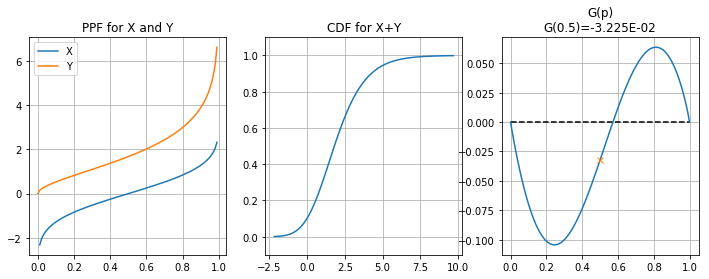

In [10]:
p1 =spstat.norm(loc=0,scale=1)
p2 =spstat.gamma(loc=0, a= 2)
main(p1,p2,cutoff=1E-8,num=300)

Gp(0.5)= -0.0322492319961


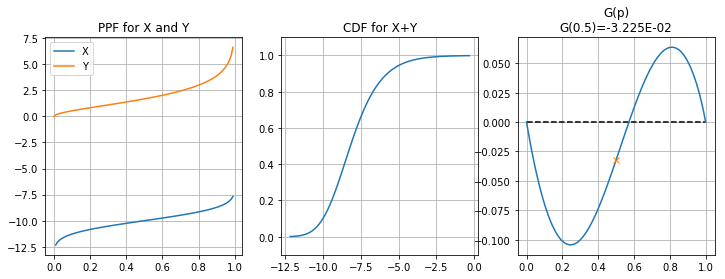

In [11]:
p1 =spstat.norm(loc=-10,scale=1)
p2 =spstat.gamma(loc=0, a= 2)
main(p1,p2,cutoff=1E-8,num=300)